# Stock market Forecasting using Time Series Analysis (TSA)

### What is a Stock market?

The stock market is a market that enables the seamless exchange of buying and selling of company stocks. Every Stock Exchange has its own Stock Index value. The index is the average value that is calculated by combining several stocks. This helps in representing the entire stock market and predicting the market’s movement over time. The stock market can have a huge impact on people and the country’s economy as a whole. Therefore, predicting the stock trends in an efficient manner can minimize the risk of loss and maximize profit.

**Here in this notebook we will forecast the stock price of  CAPITAL GROUP using suitable ARIMA/SARIMA model **

### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.


ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.



### Load all the required libraries

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# df1 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

# # Loading drive options
from google.colab import drive
drive.mount('/content/drive')

# Load the data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df1=pd.read_csv('/content/drive/MyDrive/Time Series Course/Stocks/oilx.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.0
mean,28.373985,28.421067,28.308578,28.353740,863.900000,0.0
std,1.314185,1.290672,1.328058,1.307444,832.021073,0.0
min,26.000000,26.000000,25.900000,25.900000,100.000000,0.0
25%,27.559800,27.640000,27.559800,27.625000,428.750000,0.0
50%,28.379950,28.379950,28.250000,28.325000,509.500000,0.0
75%,29.192500,29.207500,29.070000,29.070000,1074.250000,0.0
max,32.730000,32.740000,32.650000,32.665700,4090.000000,0.0


Visualize the per day closing price of the stock.

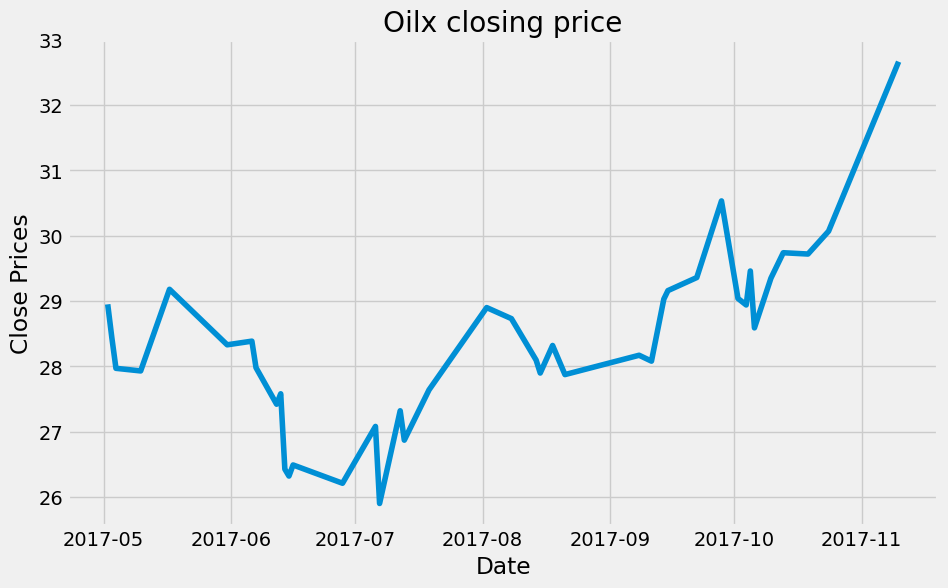

In [ ]:
#plot close price
df_close=df1['Close']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df1['Close'])
plt.title('Oilx closing price')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

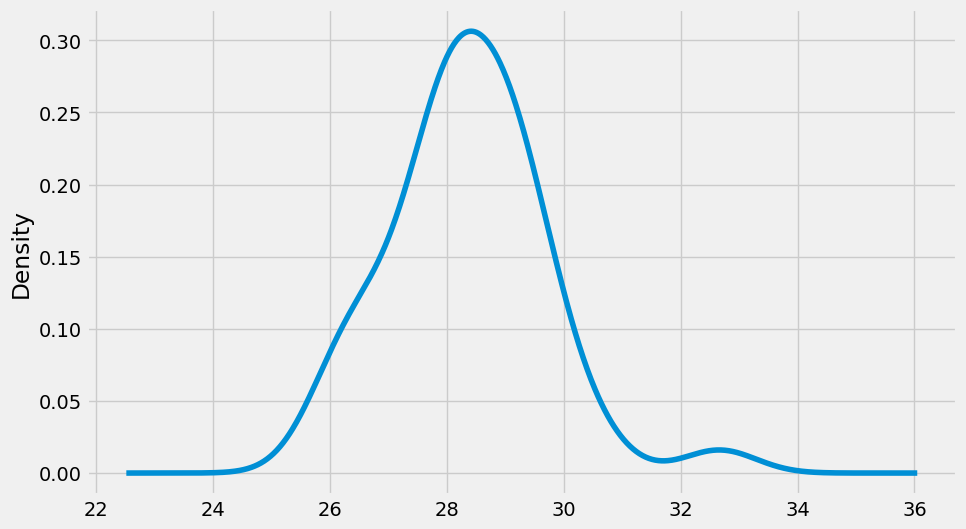

In [ ]:
#Distribution of the dataset
df_close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

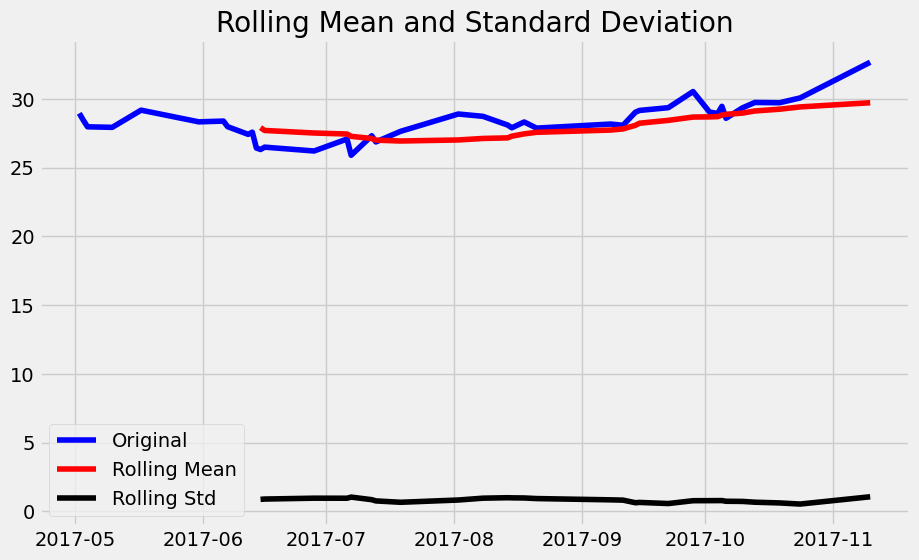

Results of dickey fuller test
Test Statistics                 0.106669
p-value                         0.966513
No. of lags used                1.000000
Number of observations used    38.000000
critical value (1%)            -3.615509
critical value (5%)            -2.941262
critical value (10%)           -2.609200
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

<Figure size 1000x600 with 0 Axes>

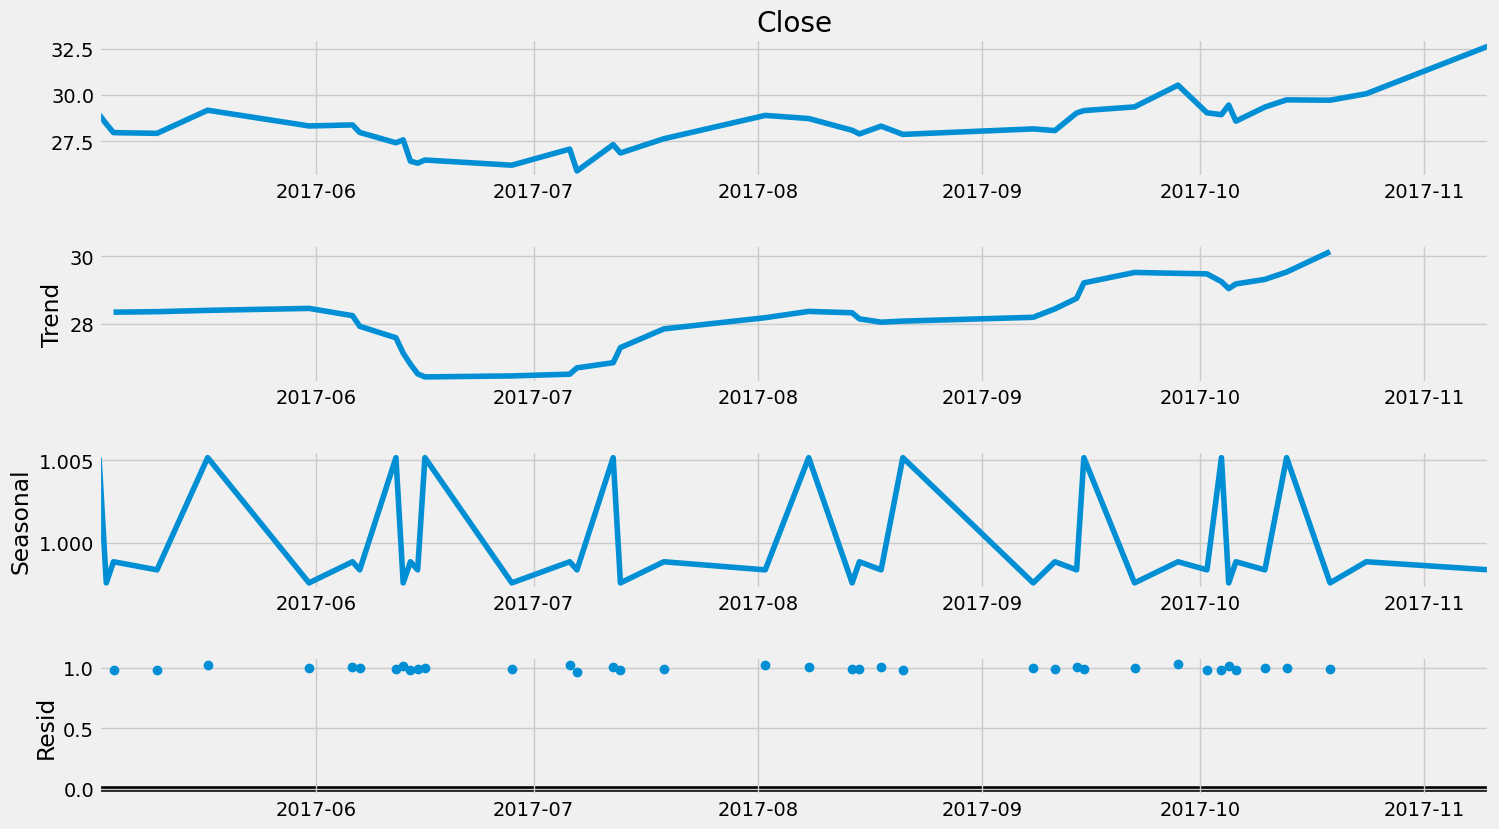

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 4)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

<Figure size 1000x600 with 0 Axes>

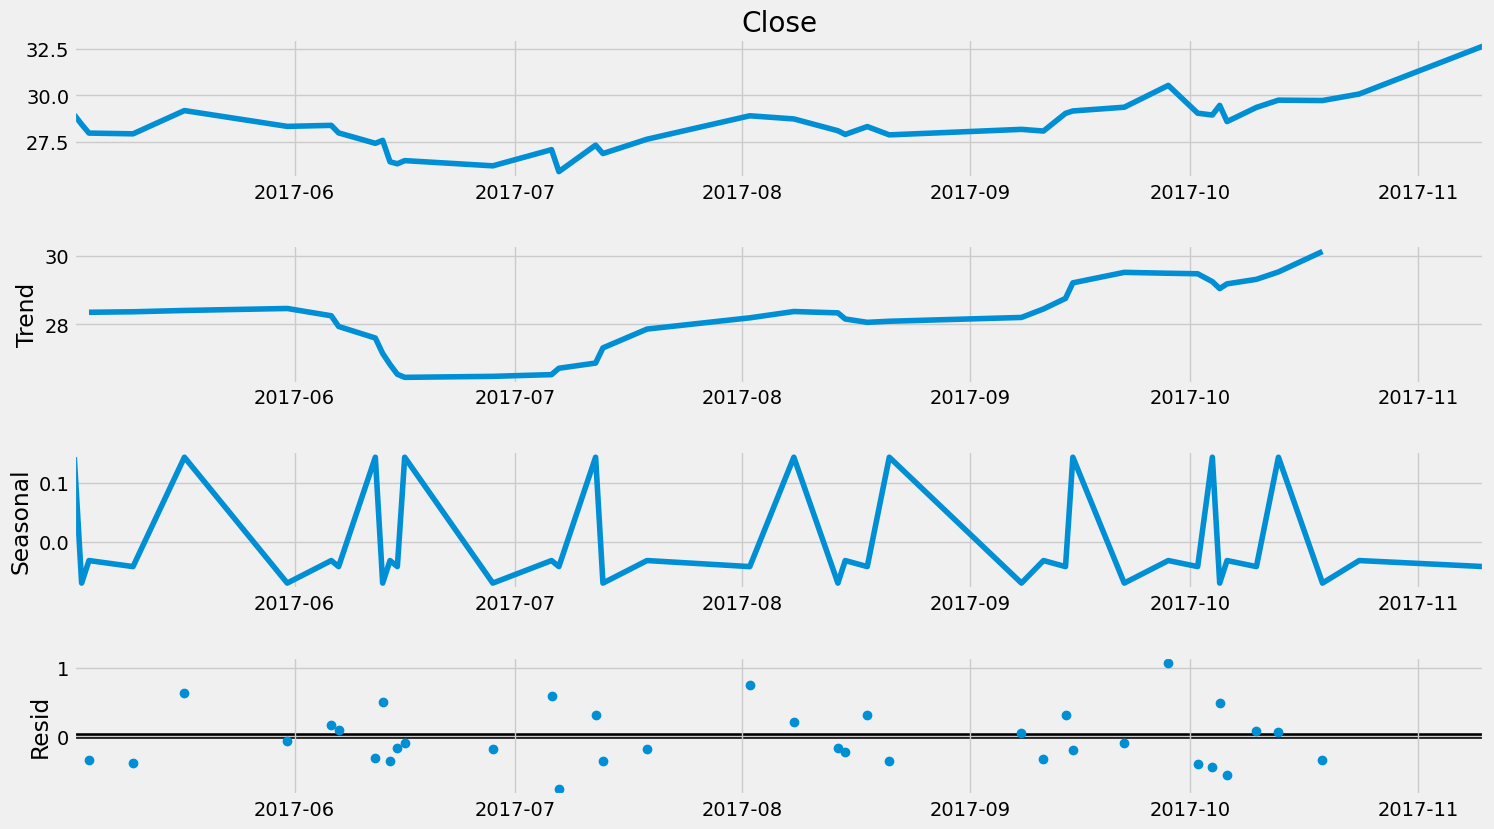

In [ ]:
result = seasonal_decompose(df_close, model='additive', period = 4)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

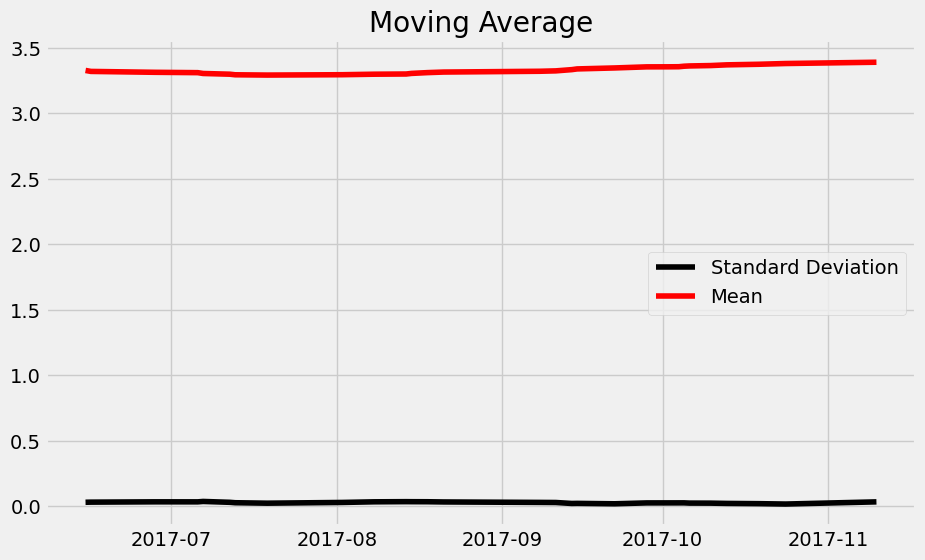

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

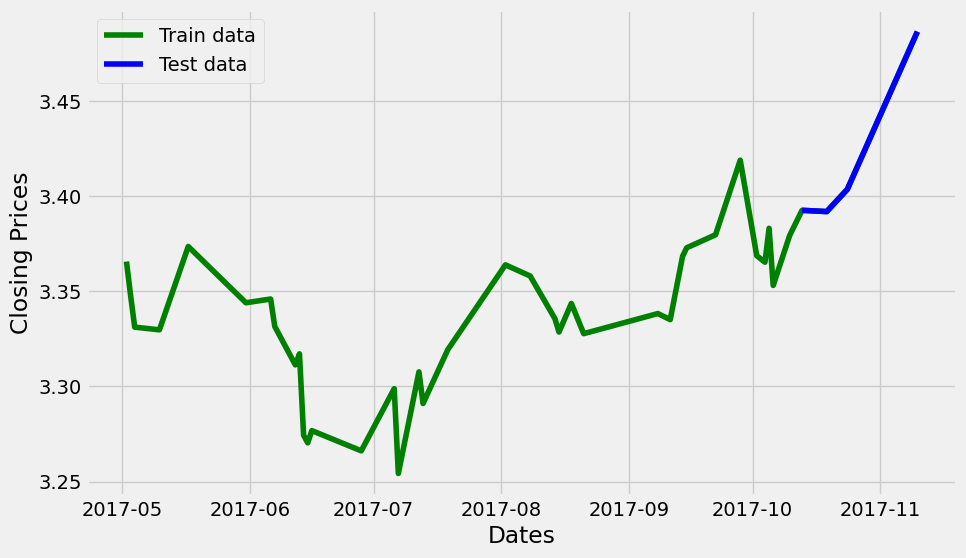

In [ ]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [ ]:
int(len(df_log)*0.9)

36

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-101.254, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-119.764, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-126.623, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-103.249, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-130.285, Time=0.31 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-125.969, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-127.890, Time=0.28 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-128.734, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-127.946, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-127.689, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-131.551, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-128.401, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-121.753, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-127.974, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[0]          

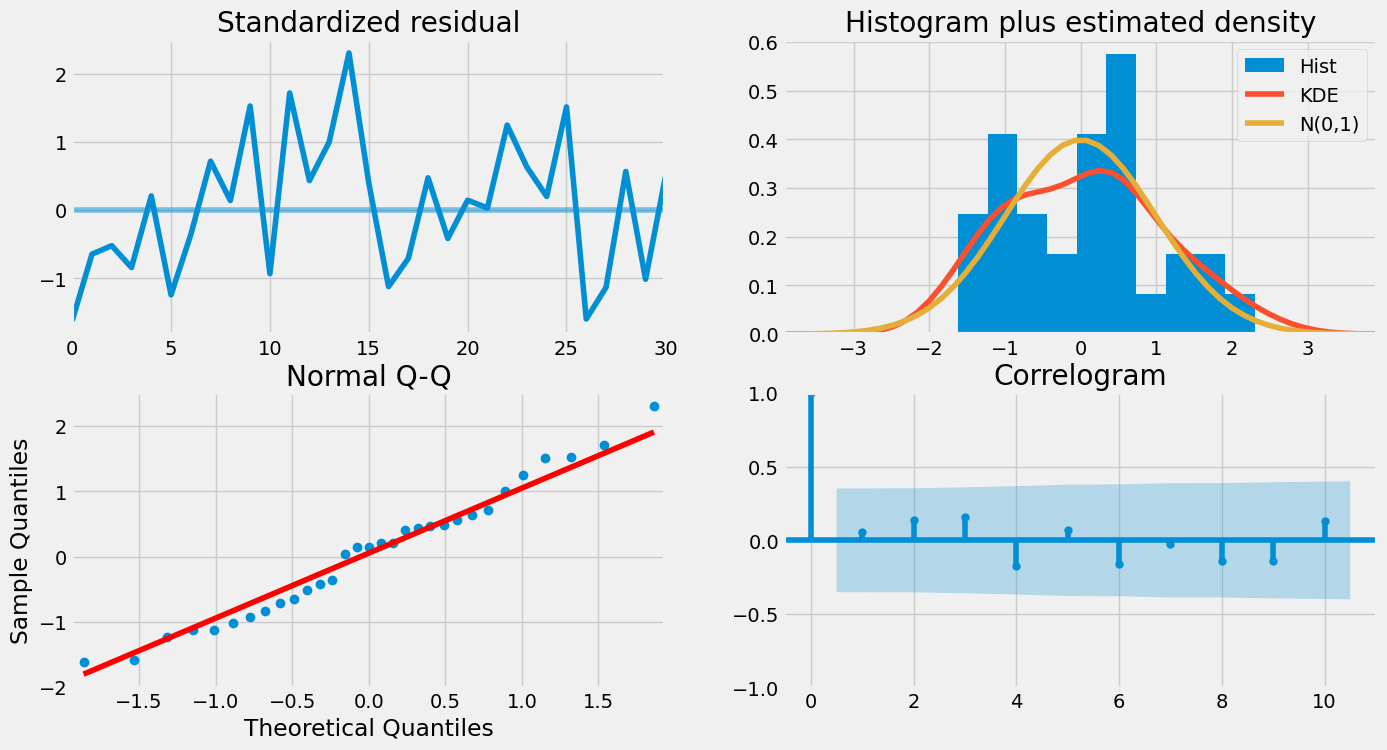

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 2, 1 and 2 respectively.**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#Modeling
# Build Model
# model = ARIMA(train_data, order=(1,1,2))
model1 = ARIMA(train_data, order=(1,2,1))
# fitted = model1.fit(disp=-1)
fitted = model1.fit()
# print(fitted.summary())
print(fitted.summary())

# result = fitted.forecast(57, alpha =0.05)

# # Make as pandas series
# fc_series = pd.Series(result[564:620],test_data.index)
# lower_series = pd.Series(result[564], test_data.index)
# upper_series = pd.Series(result[620], test_data.index)

# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(df_log, label='training data')
# plt.plot(test, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='gray', alpha=.10)
# plt.title('TSLA Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('TSLA Stock Price')
# plt.legend(loc='best', fontsize=8)
# plt.show()



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   33
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  68.775
Date:                Sat, 10 Jun 2023   AIC                           -131.551
Time:                        11:18:14   BIC                           -127.249
Sample:                             0   HQIC                          -130.149
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4212      0.177     -2.381      0.017      -0.768      -0.074
ma.L1         -0.9397      0.132     -7.112      0.000      -1.199      -0.681
sigma2         0.0006      0.000      3.248      0.0

### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [ ]:
# fitted = model1.fit(disp=False)
# # Forecast
# # fc, se, conf = fitted.forecast(212, alpha=0.05)  # 95% conf
result=fitted.forecast(int(len(df_log)*0.9), alpha=0.01)  # 95% conf


# # Make as pandas series
# fc_series = pd.Series(result[564:620],test_data.index)
# lower_series = pd.Series(result[564], test_data.index)
# upper_series = pd.Series(result[620], test_data.index)

# result[0,:]
result[int(len(df_log)*0.9)]
result[int(len(df_log)*0.9)]
result

33    3.370370
34    3.376266
35    3.375921
36    3.378204
37    3.379381
38    3.381024
39    3.382470
40    3.383999
41    3.385493
42    3.387002
43    3.388505
44    3.390010
45    3.391514
46    3.393019
47    3.394524
48    3.396028
49    3.397533
50    3.399037
51    3.400542
52    3.402046
53    3.403551
54    3.405056
55    3.406560
56    3.408065
57    3.409569
58    3.411074
59    3.412578
60    3.414083
61    3.415587
62    3.417092
63    3.418597
64    3.420101
65    3.421606
66    3.423110
67    3.424615
68    3.426119
Name: predicted_mean, dtype: float64

In [ ]:
# test_data[len(test_data)-1]
# test_data[len[test_data]]
# len(test_data)
train_data
df1
len(df1)-len(test_data)
len(df1)-len(train_data)

7

Plot the results

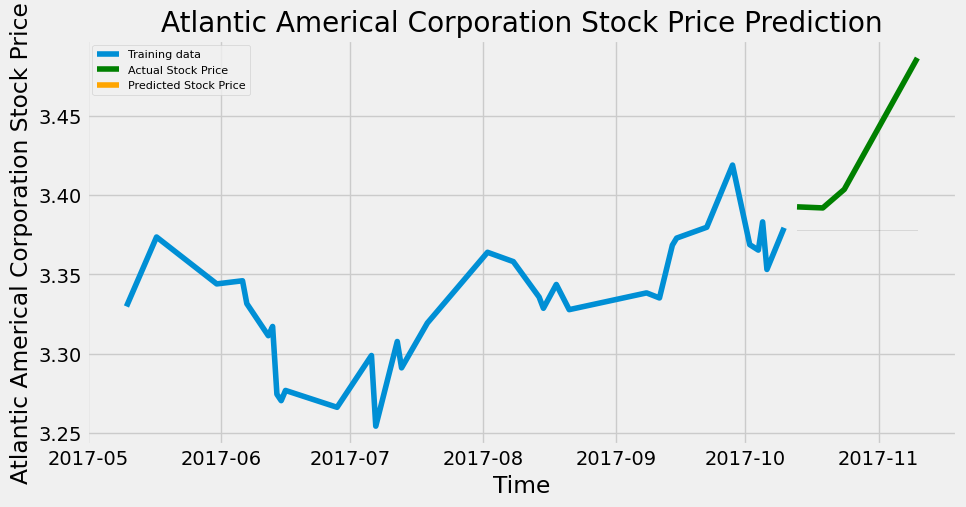

In [ ]:
# Make as pandas series

# # Make as pandas series
# fc_series = pd.Series(result[564:620],test_data.index)
# lower_series = pd.Series(result[564], test_data.index)
# upper_series = pd.Series(result[620], test_data.index)

# fc_series = pd.Series(result[0:0.7*test_data.index], index=test_data.index)
# lower_series = pd.Series(result[:, 0], index=test_data.index)
# upper_series = pd.Series(result[:, 1], index=test_data.index)
# fc_series = pd.Series(result[0:int(round(0.7*len(test_data),0))], index=test_data.index)
# lower_series = pd.Series(result[int(round(0.0*len(test_data),0))], index=test_data.index)
# upper_series = pd.Series(result[int(round(1.0*len(test_data),0))], index=test_data.index)


# fc_series = pd.Series(result[len(train_data):(len(df1)-1)], index=test_data.index)
# lower_series = pd.Series(result[len(train_data)], index=test_data.index)
# upper_series = pd.Series(result[(len(df1)-1)], index=test_data.index)


fc_series = pd.Series(result[int(len(df_log)*0.9):int(len(df_log)*1.0)], index=test_data.index)
lower_series = pd.Series(result[int(len(df_log)*0.9)], index=test_data.index)
upper_series = pd.Series(result[int(len(df_log)*0.9)], index=test_data.index)

# # Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)



# ## Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='Training data')
# plt.plot(test_data, color = 'green', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
# plt.title('Atlantic Americal Corporation Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Atlantic Americal Corporation Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'green', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=0.10)
plt.title('Atlantic Americal Corporation Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Atlantic Americal Corporation Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()






As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [ ]:

# # report performance
# print(test_data)
# print(fc_series)
# mse = mean_squared_error(test_data, result)
# print('MSE: '+str(mse))
# mae = mean_absolute_error(test_data, fc)
# print('MAE: '+str(mae))
# rmse = math.sqrt(mean_squared_error(test_data, fc))
# print('RMSE: '+str(rmse))
# mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
# print('MAPE: '+str(mape))

# test_data

### Around 2.5% MAPE implies the model is about 97.5% accurate in predicting the next 15 observations.
